In [1]:
import MySQLdb
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import PCA
from numpy.linalg import inv, svd
from scipy.linalg import sqrtm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# # uncomment the below code block to produce report friendly plots
# import matplotlib
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# font = {'size':18}

# matplotlib.rc('font', **font)

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
all_tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'NN', 'NNS', 'NNPS', 'NNP']
adj_tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
nn_tags = ['NN', 'NNS', 'NNPS', 'NNP']
good_heads = ['NOUN', 'VERB']

## Data Loading

In [5]:
db = MySQLdb.connect(host="127.0.0.1",user="yiyi", passwd="19920108",db="yelp_db")

Load restaurant review data and take a look.

In [6]:
df_all_reviews = pd.read_sql('select * from review_food;', con=db)
df_all_reviews.head()

,id,business_id,user_id,stars,date,text,useful,funny,cool
0,----X0BIDP9tA49U3RvdSQ,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",1,0,0
1,---0hl58W-sjVTKi5LghGw,Ae4ABFarGMaI5lk1i98A0w,Y6qylbHq8QJmaCRSlKdIog,4,2016-07-24,Ate the momos during the momo crawl.. Was the ...,0,0,0
2,---3OXpexMp0oAg77xWfYA,lKq4Qsz13FDcAVgp49uukQ,SnXZkRN9Yf060pNTk1HMDg,5,2012-04-07,Pizza here made my night... Good people and gr...,2,0,0
3,---65iIIGzHj96QnOh89EQ,6nKR80xEGHYf2UxAe_Cu_g,VcmSgvslHAhqWoEn16wjjw,5,2015-09-11,Great brisket sandwich as claimed. Weird that ...,0,0,0
4,---7WhU-FtzSUOje87Y4uw,Z_mJYg3vi8cPZHa1J4BALw,NKF9v-r0jd1p0JVi9h2T1w,5,2016-01-22,"Interesting food, great atmosphere, and great ...",1,1,1


In [7]:
print('loaded dataframe from MySQL. \nNumber of records:', len(df_all_reviews))
print('columns in the table:\n', df_all_reviews.columns.values)
print('number of unique restaurants:', df_all_reviews['business_id'].nunique())

loaded dataframe from MySQL. 
Number of records: 3635685
columns in the table:
 ['id' 'business_id' 'user_id' 'stars' 'date' 'text' 'useful' 'funny'
 'cool']
number of unique restaurants: 72065


Show an random sample review.

In [8]:
df_all_reviews['text'][5730]

"This place is awesome! Had lunch there yesterday & so happy it's 5 min away from my house. Great food! If you have been to Laibela it's comparable. Had the veggie/meat combo & it's huge could feed 3! Go & check it out."

Distribution of reviews by restaurant and user.

number of unique businesses:  72065


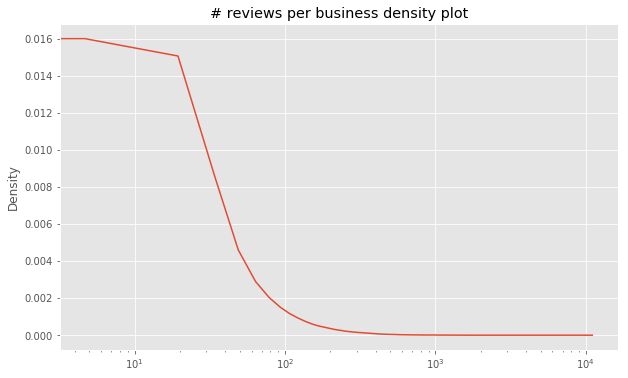

In [9]:
# bins = [0, 5, 10, 100, 250, 500, 1000, 3000]
bins = np.logspace(0, 12, num=20, endpoint=True, base=2)
review_counts = df_all_reviews['business_id'].value_counts()

review_counts.plot(kind='density', 
                   title='# reviews per business density plot', 
                   figsize=(10,6), 
                   logx=True)
print('number of unique businesses: ', 
      df_all_reviews['business_id'].nunique())

number of unique users:  960262


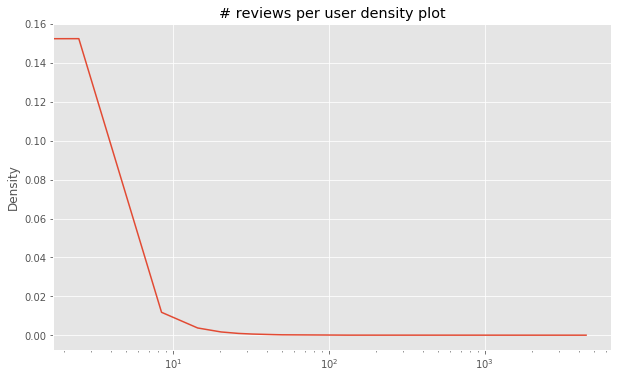

In [10]:
review_counts = df_all_reviews['user_id'].value_counts()
review_counts.plot(kind='density', 
                   title='# reviews per user density plot', 
                   figsize=(10,6), 
                   logx=True)
print('number of unique users: ', 
      df_all_reviews['user_id'].nunique())

In [11]:
review_counts = pd.DataFrame(df_all_reviews.groupby('user_id', as_index=False).size(), 
                                columns =['num_reviews'])
review_counts.reset_index(inplace=True)
review_counts['bin'] = pd.cut(review_counts['num_reviews'], 
                              bins=[0, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000])
review_counts['bin'].value_counts()

(0, 1]           518121
(1, 5]           317199
(5, 10]           67726
(10, 50]          50354
(50, 100]          4675
(100, 500]         2135
(500, 1000]          46
(1000, 5000]          6
(5000, 10000]         0
Name: bin, dtype: int64

Load restaurant data.

In [12]:
df_all_biz = pd.read_sql('select * from business;', con=db)
print('loaded dataframe from MySQL. \nNumber of records:', len(df_all_biz))

loaded dataframe from MySQL. 
Number of records: 174567


*** 

## Feature Generation
### Featurization of text reviews using Spacy

Proposed Features:
* `descriptions`: Descriptive words such as good, tasty, terrible, so adjectives and adverbs are extracted
* `bigrams`: consecutive 2-word pairs with one of the words being an adjective or adverb
* `word pairs`: adjective/adverb with its parent in the dependency parsing tree, if the parent is a noun/verb

In [13]:
def parse_doc(doc, d=True, b=True, w=True):
    filter_tags = adj_tags
    # adjectives and adverbs
    descriptions, bigrams, word_pairs = None, None, None
    
    if d:
        descriptions = [t.lemma_ for t in doc 
                        if (t.tag_ in filter_tags 
                            and t.is_alpha
                            and not t.is_stop)]
    
    # bigrams
    if b:
        l = len(doc)
        bigrams = [(t.lemma_ + ' ' +  t.nbor(1).lemma_) for i, t in enumerate(doc) 
                   if (i < l-1
                       and (t.tag_ in filter_tags or t.nbor(1).tag_ in filter_tags)
                       and (t.is_alpha and t.nbor(1).is_alpha)
                       and not (t.is_stop or t.nbor(1).is_stop)
                       and (t.lemma_ != 'be' and t.nbor(1).lemma_ != 'be'))]

    # word pairs
    if w:
        word_pairs = [(t.lemma_ + ' ' + t.head.lemma_) for t in doc
                      if (t.tag_ in filter_tags 
                          and t.head.pos_ in good_heads
                          and (t.is_alpha and t.head.is_alpha)
                          and not (t.is_stop or t.head.is_stop)
                          and t.lemma_ != 'be')]
    
    return descriptions, bigrams, word_pairs

def parse_docs(reviews):
    print("~~~~~ review feature extraction ~~~~~")
    
    n = len(reviews)
    print("total number of reviews: ", n)
    start_time = time.time()
    descriptions, bigrams, word_pairs = [], [], []
    i = 0
    
    for doc in nlp.pipe(reviews.astype('unicode').values):
        if doc.is_parsed:
            d, b, w = parse_doc(doc)
            descriptions.append(d)
            bigrams.append(b)
            word_pairs.append(w)
        else:
            descriptions.append(None)
            bigrams.append(None)
            word_pairs.append(None)
        
        i += 1
        if i % 10 == 0:
            print('Number of reviews process: {:7d} ({:4.0f}% complete)'.format(
                i, i/n*100), end='\r', flush=True)
    
    print("")
    print("--- %s seconds ---" % (time.time() - start_time))
    return descriptions, bigrams, word_pairs

Set a filter to only look at restaurants with review counts >= min_reviews. We then sample a subset of restaurants to speed up computation.

In [14]:
min_reviews = 50
reviews_per_biz = df_all_reviews['business_id'].value_counts()
f = reviews_per_biz > min_reviews 

# get a large sample
k = 1000
biz_ids = np.array(reviews_per_biz[f].index) 
idx = np.random.permutation(f.sum())[:k]
sample_biz = pd.DataFrame(biz_ids[idx], columns =['business_id'])
assert sample_biz.shape[0] == k

df_sample = df_all_reviews.merge(sample_biz, on='business_id')

# print out some information
print('dim of sample:', df_sample.shape)
df_sample.head()

dim of sample: (185354, 9)


,id,business_id,user_id,stars,date,text,useful,funny,cool
0,--0pfY3vQilgl20btE0fVQ,5BPv_vAnRp5EKdmacqvrLw,wbYWgTS-vzgfVYV_C1qhig,4,2013-05-19,An absolute favourite of mine....I don't under...,5,2,3
1,-KySikxUI3fyOnou4TQ6sA,5BPv_vAnRp5EKdmacqvrLw,6SGqUw1as8N7AEjAb3mRsA,3,2011-01-12,"Located in downtown, so prepare to pay for par...",0,0,0
2,0U6nFPOrRKww-6MoNRlVxg,5BPv_vAnRp5EKdmacqvrLw,dtanlcid8_m1L49ZK1YPfw,3,2011-12-09,Great little Thai restaurant located near the ...,0,0,0
3,1yBXNPVYwFGcQaOhnKEAjg,5BPv_vAnRp5EKdmacqvrLw,HFItzRohDHZvcKDrM6ABZg,3,2011-03-08,Went to Pi-Tom's today with the amazing Karl R...,1,1,2
4,2wDax1QF33FItjTfspF_6g,5BPv_vAnRp5EKdmacqvrLw,XIkPvspzRAoEp7McGt9rdw,3,2011-06-16,2.5 Stars. The highlight of my dining experien...,4,0,3


Featurize the sample and save the features to disk for future retrieval.

In [15]:
# # featurization
# d, b, w = parse_docs(df_sample['text'])
# df_sample['descriptions'] = d
# df_sample['bigrams'] = b
# df_sample['word_pairs'] = w

# # save sample to disk for future retrieval 
# filename = '1k_small.pkl'
# df_sample.to_pickle(filename)

In [16]:
filename = '10k_medium.pkl'
df_sample = pd.read_pickle(filename)
df_sample.head()

,id,business_id,user_id,stars,date,text,useful,funny,cool,descriptions,bigrams,word_pairs
0,---94vtJ_5o_nikEs6hUjg,R1PQEK6qvrZVC9qcWfKvDA,c2MQ_LPuvtiiKFR_-OY9pg,5,2014-09-17,One of my absolute favorite restaurants! I usu...,1,0,0,"[absolute, favorite, usually, finally, privile...","[absolute favorite, favorite restaurant, final...","[absolute restaurant, favorite restaurant, fin..."
1,-0kMtT3KIXeBDNyhYzw0fA,R1PQEK6qvrZVC9qcWfKvDA,Y0UAHzk3dmfmN05h3VJuKA,5,2015-12-23,Came in here to try something new.. Definetly ...,0,1,0,"[new, definetly, impressed, instead, amazing, ...",[definetly impressed],"[impressed came, instead come]"
2,0bNQt1SuA3JLF52sghALqg,R1PQEK6qvrZVC9qcWfKvDA,1Jj7LukYTA7oisUSC1o_fg,4,2015-05-11,Decided to check out Braddah's today on accoun...,1,1,1,"[good, exceptional, awesome, ok, forgettable, ...",[savory separate],"[savory like, little flavor]"
3,0fubQ5SDueaI5OqK0QCRZA,R1PQEK6qvrZVC9qcWfKvDA,Hqts8p_V5HLQeO5Q3czkJQ,3,2014-10-22,Not your regular Hawaiian BBQ joint; don't com...,0,0,0,"[regular, hawaiian, esque, flavorful, disappoi...","[regular hawaiian, hawaiian bbq, esque assembl...","[regular joint, hawaiian joint, esque line, or..."
4,0qOU0aECP-wQxxjlMQ4ODw,R1PQEK6qvrZVC9qcWfKvDA,8VEBLmuQbBm67ylC47tTwQ,5,2015-06-27,Me and the family ate here twice during a 5 da...,1,0,0,"[twice, tasty, soft, great, exactly, clear, good]","[soft tacos, clear winner]","[twice eat, soft tacos, exactly taste, clear w..."


Take a look at the features.

In [17]:
# take a look at all the features
feature_col = 'word_pairs'
feats = df_sample[feature_col].values
feats_flattened = [f for feat in feats for f in feat]
c = Counter(feats_flattened)
c.most_common(10)

[('good food', 21368),
 ('highly recommend', 18860),
 ('great place', 18503),
 ('great food', 15397),
 ('great service', 15178),
 ('good place', 13846),
 ('good service', 10894),
 ('happy hour', 10482),
 ('good thing', 10025),
 ('definitely come', 8856)]

### Count vectorization
Transform word list into columns of words/bigrams using count vectorization.

In [18]:
def standardize(X,Y):
    ss_x = StandardScaler()
    ss_y = StandardScaler()
    
    X = ss_x.fit_transform(X)
    Y = ss_y.fit_transform(Y)
    
    return X,Y

def agg_feature_by_biz(df, biz_col, feature_col):
    print("~~~~~ aggregating feature: {} ~~~~~".format(feature_col))
    start_time = time.time()
    
    df_sample_reviews = df.groupby(biz_col, as_index=False)[feature_col].agg(sum)

    print("--- %s seconds ---" % (time.time() - start_time))
    print()
    return df_sample_reviews


def word_list_vectorizer(reviews, params):
    def dummy_tokenizer(sentence):
        return sentence

    def dummy_preprocess(sentence):
        return sentence

    vec = CountVectorizer(tokenizer=dummy_tokenizer, 
                          preprocessor=dummy_preprocess,
                          **params)

    count_matrix = vec.fit_transform(reviews).toarray()
    id_to_word = {vec.vocabulary_[word]: word for word in vec.vocabulary_}
    return count_matrix, id_to_word


def text_to_feature(df, biz_col, feature_col, params):
    df_reviews = agg_feature_by_biz(df, biz_col, feature_col)
    reviews = df_reviews[feature_col]
    
    count, feature_dict = word_list_vectorizer(reviews, params)
    total_count = count.sum(axis = 1)
    # handle division by 0
    total_count[np.where(total_count == 0)[0]] = 1 
    # raw count -> frequency
    count = count / total_count[:, np.newaxis] 
    
    df_count = pd.DataFrame(count)
    df_count.columns = [feature_dict[i] for i in range(len(feature_dict))]
    df_count[biz_col] = df_reviews[biz_col]
    return df_count


def move_biz_col_forward(df, biz_col = 'business_id'):
    cols = list(df.columns)
    biz_col_idx = cols.index(biz_col)
    cols = [cols[biz_col_idx]] + cols[:biz_col_idx] + cols[biz_col_idx+1:]
    df = df[cols]
    return df

In [19]:
params = {'min_df': 10, 
          'max_df': 0.5,
          'max_features': 100}

biz_col = 'business_id'
feature_col = 'descriptions'
df_descriptions = text_to_feature(df_sample, biz_col, feature_col, params)

feature_col = 'word_pairs'
df_wordpairs = text_to_feature(df_sample, biz_col, feature_col, params)

~~~~~ aggregating feature: descriptions ~~~~~
--- 42.33356523513794 seconds ---

~~~~~ aggregating feature: word_pairs ~~~~~
--- 40.26867413520813 seconds ---



***
## Dimensionality Reduction

Pick one or more of the text features to use for our dimensionality reduction. Below `word pairs` is used

In [20]:
# create feature dataframe by combining all text features
# df_features = df_descriptions.merge(df_wordpairs, on = biz_col)
df_features = df_wordpairs

# # rearrange column names so business_id is the first col
# cols = list(df_features.columns)
# biz_col_idx = cols.index(biz_col)
# cols = [cols[biz_col_idx]] + cols[:biz_col_idx] + cols[biz_col_idx+1:]
# df_features = df_features[cols]
df_features = move_biz_col_forward(df_features)

# creating feature lookup by column index
feature_dict = {i:feat for i, feat in enumerate(list(df_features.columns[1:]))}

In [21]:
df_features.head()

,business_id,absolutely love,amazing food,authentic food,away blow,away stay,away walk,bad experience,bad service,big deal,...,perfectly cook,poor service,prime rib,quickly come,reasonable price,reasonably price,second time,short rib,small portion,sweet fry
0,--6MefnULPED_I942VcFNA,0.000000,0.000000,0.0,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,--9e1ONYQuAa-CB_Rrw7Tw,0.005686,0.009748,0.0,0.012998,0.004062,0.006499,0.004062,0.002437,0.004062,...,0.090983,0.003249,0.006499,0.005686,0.002437,0.010561,0.018684,0.003249,0.003249,0.0
2,--DaPTJW3-tB1vP-PfdTEg,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.030303,0.000000,0.060606,0.000000,0.060606,0.000000,0.000000,0.000000,0.0
3,--KCl2FvVQpvjzmZSPyviA,0.000000,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0
4,--Ni3oJ4VOqfOEu7Sj2Vzg,0.000000,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Prepare X and y for PCA and CCA.

In [22]:
X = df_features.iloc[:, 1:].as_matrix()

ratings_data = df_features.merge(df_all_biz, left_on='business_id', right_on='id')
y = ratings_data['stars'].values
if len(y.shape) == 1: y = np.reshape(y, (-1, 1))

# feature scaling and standardization
# X, y = standardize(X,y)

print('dim of features:', X.shape)
print('dim of output (rating):', y.shape)
print('percentage of restaurants with non-zero features:{:.1f}%'.format(
    X.sum(axis=1).sum()/X.shape[0]*100))

dim of features: (10000, 100)
dim of output (rating): (10000, 1)
percentage of restaurants with non-zero features:97.6%


### PCA

In [23]:
pca = PCA(n_components=5)
pca.fit(X)

print("total variance explained:", pca.explained_variance_ratio_.sum())

total variance explained: 0.17730513206715498


5 principal components.

In [24]:
max_ids = np.argsort(abs(pca.components_), axis=1)[:, -10:][:, ::-1]

for i, pci in enumerate(max_ids):
    print("No. {} principal component".format(i + 1))
    print("Top {} features with the highest abs weights: ".format(10))
    print(['{}: {:.2f}'.format(feature_dict[j], pca.components_[i,j]) for j in pci ])
    print()

No. 1 principal component
Top 10 features with the highest abs weights: 
['fast food: 0.67', 'great place: -0.66', 'good place: -0.17', 'highly recommend: -0.12', 'friendly staff: -0.11', 'great selection: -0.08', 'bad experience: 0.07', 'good food: 0.07', 'bad service: 0.07', 'good service: 0.06']

No. 2 principal component
Top 10 features with the highest abs weights: 
['great place: 0.68', 'fast food: 0.63', 'highly recommend: -0.30', 'good food: -0.12', 'great service: -0.08', 'good pizza: -0.06', 'good taste: -0.05', 'chinese food: -0.05', 'definitely recommend: -0.04', 'great food: -0.04']

No. 3 principal component
Top 10 features with the highest abs weights: 
['good place: 0.85', 'highly recommend: -0.44', 'great service: -0.20', 'great place: -0.14', 'friendly staff: -0.07', 'good pizza: 0.06', 'good food: 0.06', 'forward look: -0.05', 'fast food: -0.04', 'great selection: -0.04']

No. 4 principal component
Top 10 features with the highest abs weights: 
['highly recommend: 0.

Numerical feature importance for the 1st principal component.

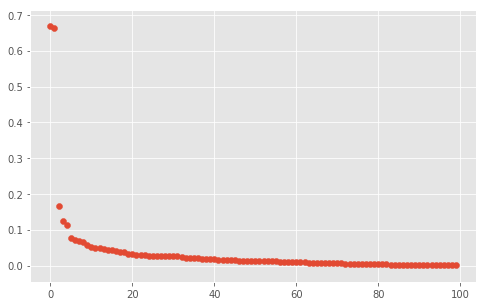

In [25]:
proj_1d = abs(pca.components_[0])
idx = np.argsort(proj_1d)[::-1]
plt.figure(figsize=(8,5))
plt.scatter(range(len(idx)), proj_1d[idx])

2D projection visualization.

In [26]:
# Plot restaurants by first two PCA dimensions
pca = PCA(n_components=2)
transformed_features = pca.fit_transform(X)

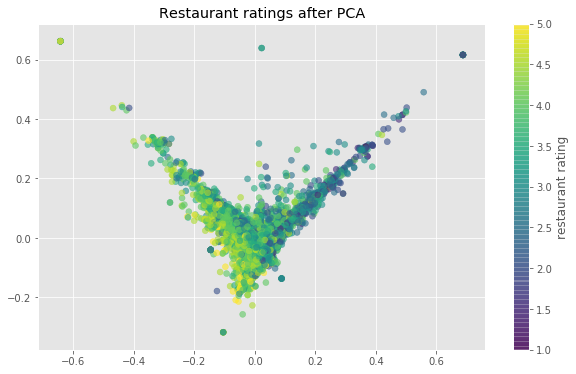

In [27]:
plt.figure(figsize=(10,6))
plt.scatter(transformed_features[:, 0],     # Select first column
            transformed_features[:, 1],     # Select second column
            c=y.flatten(), alpha=0.6)
plt.colorbar(label='restaurant rating')
plt.title('Restaurant ratings after PCA')
plt.show()

### CCA

In [28]:
# code adapted from HW 6
def compute_covariance_matrix(X,Y):    
    N = len(X)
    X = np.array(X)
    Y = np.array(Y)
    C_XY = X.T @ Y
    
    return C_XY/float(N)


def get_CCA_components(X, Y, k):
    C_XY = compute_covariance_matrix(X,y)
    C_XX = compute_covariance_matrix(X,X)
    C_YY = compute_covariance_matrix(y,y)

    dim_x = C_XX.shape[0]
    dim_y = C_YY.shape[0]

    white_cov = inv(sqrtm(C_XX + 1e-5*np.eye(dim_x)))
    B = inv(sqrtm(C_YY + 1e-5*np.eye(dim_y)))
    C = np.matmul(white_cov, np.matmul(C_XY, B))
    u,s,d = svd(C)

    proj = np.matmul(u[:,0:k].T, white_cov) 
    return proj

Top 5 projection vectors.

In [29]:
if len(y.shape) == 1: y = np.reshape(y, (-1, 1))
proj = get_CCA_components(X, y, 5)

max_ids = np.argsort(abs(proj), axis=1)[:, -10:][:, ::-1]

for i, pci in enumerate(max_ids):
    print("Top {} principal component".format(i))
    print("Top words with the highest weights: ")
    print(['{}:{:.2f}'.format(feature_dict[j], proj[i,j]) for j in pci ])
    print()

Top 0 principal component
Top words with the highest weights: 
['favorite restaurant:1.62', 'highly recommend:1.58', 'little place:1.49', 'excellent food:1.48', 'delicious food:1.44', 'definitely go:1.43', 'definitely come:1.41', 'authentic food:1.36', 'great atmosphere:1.35', 'great flavor:1.35']

Top 1 principal component
Top words with the highest weights: 
['amazing food:51.35', 'absolutely love:-2.36', 'authentic food:-0.98', 'good food:-0.95', 'great food:-0.84', 'delicious food:-0.80', 'perfectly cook:-0.70', 'highly recommend:-0.69', 'excellent food:-0.63', 'great experience:-0.59']

Top 2 principal component
Top words with the highest weights: 
['authentic food:43.19', 'mexican food:-3.19', 'absolutely love:-2.20', 'good restaurant:-1.53', 'delicious food:-1.47', 'good food:-1.28', 'favorite restaurant:-1.21', 'chinese food:-1.15', 'chinese restaurant:-1.09', 'mexican restaurant:-1.06']

Top 3 principal component
Top words with the highest weights: 
['away blow:40.74', 'absolu

Feature weights magnitude for 1st projection vector.

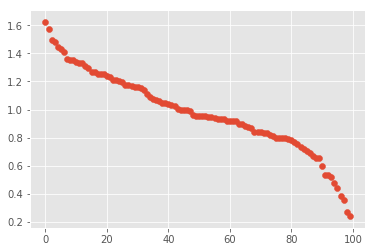

In [30]:
proj_1d = abs(proj[0])
idx = np.argsort(proj_1d)[::-1]
plt.scatter(range(len(idx)), proj_1d[idx])

2D projection visualization.

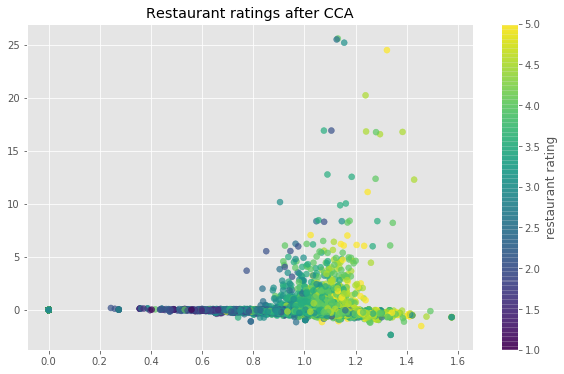

In [31]:
proj_2d = proj[:2,:]
transformed_features = np.matmul(proj_2d, X.T).T

# Plot restaurants by first two CCA dimensions
plt.figure(figsize=(10,6))
plt.scatter(transformed_features[:, 0],     # Select first column
            transformed_features[:, 1],     # Select second column
            c=y.flatten(), alpha=0.7)
plt.colorbar(label='restaurant rating')
plt.title('Restaurant ratings after CCA')
plt.show()

***

## Prediction

### Test user sampling
Sample test user IDs and create corresponding train and validation datasets.

In [32]:
def sample_k_test_uids(review_counts, k, lower, upper):
    uid = review_counts[(review_counts['num_reviews'] > lower) & 
                        (review_counts['num_reviews'] <= upper)]['user_id']
    test_uid = np.random.permutation(uid)[:k]
    return test_uid

Group users by their review counts and evaluate performance for each group.

In [33]:
review_counts = pd.DataFrame(df_sample.groupby('user_id', as_index=False).size(), 
                                columns =['num_reviews'])
review_counts.reset_index(inplace=True)
review_counts['bin'] = pd.cut(review_counts['num_reviews'], 
                              bins=[0, 1, 5, 10, 50, 100, 500, 1000, 5000])
review_counts['bin'].value_counts()

(0, 1]          231629
(1, 5]           84093
(5, 10]           9647
(10, 50]          5513
(50, 100]          181
(100, 500]          37
(500, 1000]          1
(1000, 5000]         0
Name: bin, dtype: int64

Sample test user IDs.

In [34]:
bounds = [(1, 5), (5, 10), (10, 50), (50, 100), (100, 500)]
num_test_users = [1000, 1000, 500, 50, 10]
test_sizes = [1, 1, 0.1, 0.1, 0.1]

test_uids = []
i = 0
for lower, upper in bounds:
    test_uids.append(sample_k_test_uids(review_counts, 
                                        num_test_users[i], 
                                        lower, upper))
    i += 1

Get train and test dataset.
* `df_train` is used to generate feature representations of restaurants
* `df_test` is used to evaluate algorithm performance

In [35]:
test_uids_flatten = [uid for uids in test_uids for uid in uids]
df_test_uids = pd.DataFrame(test_uids_flatten, columns = ['user_id'])
df_test = df_sample.merge(df_test_uids, on = 'user_id')

train_uids = set(review_counts['user_id']) - set(test_uids_flatten)
df_train_uids = pd.DataFrame(list(train_uids), columns = ['user_id'])
df_train = df_sample.merge(df_train_uids, on = 'user_id')

Create X by constructing feature representations of the restaurants from list of word pairs.

In [36]:
params = {'min_df': 10, 
          'max_df': 0.5,
          'max_features': 100}

biz_col = 'business_id'
feature_col = 'word_pairs'
df_train_feat = text_to_feature(df_train, biz_col, feature_col, params)

~~~~~ aggregating feature: word_pairs ~~~~~
--- 43.45204710960388 seconds ---



In [37]:
# move business_id column to the first
df_train_feat = move_biz_col_forward(df_train_feat)

# creating feature lookup by column index
feature_dict = {i:feat for i, feat in enumerate(list(df_train_feat.columns[1:]))}
df_train_feat.head()

,business_id,absolutely love,amazing food,authentic food,away blow,away stay,away walk,bad experience,bad service,big deal,...,perfectly cook,poor service,prime rib,quickly come,reasonable price,reasonably price,second time,short rib,small portion,sweet fry
0,--6MefnULPED_I942VcFNA,0.000000,0.000000,0.0,0.000000,0.000000,0.050000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,--9e1ONYQuAa-CB_Rrw7Tw,0.005824,0.009983,0.0,0.013311,0.003328,0.005824,0.003328,0.002496,0.00416,...,0.08985,0.003328,0.006656,0.005824,0.002496,0.010815,0.018303,0.003328,0.003328,0.0
2,--DaPTJW3-tB1vP-PfdTEg,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.032258,0.000000,0.064516,0.000000,0.064516,0.000000,0.000000,0.000000,0.0
3,--KCl2FvVQpvjzmZSPyviA,0.000000,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.0
4,--Ni3oJ4VOqfOEu7Sj2Vzg,0.000000,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [38]:
def get_data_for_test_user(df_sample, df_train_feat, test_user_id, test_size=1):
    # get business ids and ratings for given user
    test_user_data = df_sample[df_sample['user_id'] == test_user_id]
    
    # remove restaurants not found on the train set
    test_user_data = test_user_data[['business_id', 'stars']].merge(
        df_train_feat, on = 'business_id')
    
    # get train test split
    yt = test_user_data['stars'].values
    Xt = test_user_data.drop(columns = ['stars', 'business_id']).as_matrix()
    X_train, X_test, y_train, y_test = train_test_split(
        Xt, yt, test_size=test_size, random_state=38562014)
    return X_train, X_test, y_train, y_test

def evaluate_models(df_sample, df_train_feat, test_uids):
    clf = Ridge(alpha=1.0)
    rmses = []
    for i, user_group in enumerate(test_uids):
        print('group {}: users with ({}, {}] reviews'.format(
            i, bounds[i][0], bounds[i][1]))
        test_size = test_sizes[i]
        se, num_pred = 0, 0
        start_time = time.time()

        for test_user_id in user_group:
            X_train, X_test, y_train, y_test = get_data_for_test_user(
                df_sample, df_train_feat, test_user_id, 
                test_size=test_size)
            clf.fit(X_train, y_train)
            se += np.sum((clf.predict(X_test)-y_test)**2)
            num_pred += len(y_test)

        print("runtime: {:.2f} sec".format(time.time() - start_time))

        rmse = np.sqrt(se/num_pred)
        rmses.append(rmse)

        print('total number of predictions: ', num_pred)
        print('root mean squared error: {:.3f}'.format(rmse))
        print()
    return rmses

Feature representation 1 (full with d = 5) and performance.

In [39]:
# full d=100 features
rmses_full = evaluate_models(df_sample, df_train_feat, test_uids)

group 0: users with (1, 5] reviews
runtime: 37.34 sec
total number of predictions:  1000
root mean squared error: 1.726

group 1: users with (5, 10] reviews
runtime: 37.88 sec
total number of predictions:  1000
root mean squared error: 1.276

group 2: users with (10, 50] reviews
runtime: 18.84 sec
total number of predictions:  1172
root mean squared error: 1.148

group 3: users with (50, 100] reviews
runtime: 1.88 sec
total number of predictions:  360
root mean squared error: 0.929

group 4: users with (100, 500] reviews
runtime: 0.41 sec
total number of predictions:  153
root mean squared error: 0.834



Feature representation 2 (PCA with d = 5) and performance.

In [40]:
# top 5 PCA components
X = df_train_feat.iloc[:, 1:]
pca = PCA(n_components=5)
transformed_features = pca.fit_transform(X)

# get train features
df_train_feat_pca = pd.DataFrame(transformed_features, 
                                 columns=['pca_{}'.format(i+1) for i in range(5)])
df_train_feat_pca['business_id'] = df_train_feat['business_id']
df_train_feat_pca = move_biz_col_forward(df_train_feat_pca)

In [41]:
rmses_pca = evaluate_models(df_sample, df_train_feat_pca, test_uids)

group 0: users with (1, 5] reviews
runtime: 36.94 sec
total number of predictions:  1000
root mean squared error: 1.727

group 1: users with (5, 10] reviews
runtime: 36.74 sec
total number of predictions:  1000
root mean squared error: 1.276

group 2: users with (10, 50] reviews
runtime: 18.72 sec
total number of predictions:  1172
root mean squared error: 1.148

group 3: users with (50, 100] reviews
runtime: 1.84 sec
total number of predictions:  360
root mean squared error: 0.926

group 4: users with (100, 500] reviews
runtime: 0.37 sec
total number of predictions:  153
root mean squared error: 0.839



Feature representation 3 (CCA with d = 5) and performance.

In [42]:
# top 5 CCA components
X = df_train_feat.iloc[:, 1:]

ratings_data = df_train_feat.merge(df_all_biz, 
                                   left_on='business_id', right_on='id')
y = ratings_data['stars'].values
if len(y.shape) == 1: y = np.reshape(y, (-1, 1))
proj = get_CCA_components(X, y, 5)
transformed_features = np.matmul(proj, X.T).T

# get train features
df_train_feat_cca = pd.DataFrame(transformed_features, 
                                 columns=['cca_{}'.format(i+1) for i in range(5)])
df_train_feat_cca['business_id'] = df_train_feat['business_id']
df_train_feat_cca = move_biz_col_forward(df_train_feat_cca)

df_train_feat_cca.head()

,business_id,cca_1,cca_2,cca_3,cca_4,cca_5
0,--6MefnULPED_I942VcFNA,0.923836,-0.073256,-0.620372,-0.058778,-0.089386
1,--9e1ONYQuAa-CB_Rrw7Tw,1.066220,0.199480,-0.221161,0.266256,-0.058024
2,--DaPTJW3-tB1vP-PfdTEg,1.032072,-0.156847,-0.163211,-0.157965,-0.150744
3,--KCl2FvVQpvjzmZSPyviA,1.003697,-0.281327,-0.450481,-0.191633,3.943485
4,--Ni3oJ4VOqfOEu7Sj2Vzg,0.840970,-0.095928,-0.169297,-0.237118,-0.171871


In [43]:
rmses_cca = evaluate_models(df_sample, df_train_feat_cca, test_uids)

group 0: users with (1, 5] reviews
runtime: 37.01 sec
total number of predictions:  1000
root mean squared error: 1.738

group 1: users with (5, 10] reviews
runtime: 36.97 sec
total number of predictions:  1000
root mean squared error: 1.363

group 2: users with (10, 50] reviews
runtime: 18.95 sec
total number of predictions:  1172
root mean squared error: 1.197

group 3: users with (50, 100] reviews
runtime: 1.88 sec
total number of predictions:  360
root mean squared error: 0.959

group 4: users with (100, 500] reviews
runtime: 0.38 sec
total number of predictions:  153
root mean squared error: 0.829



Plot the performances of all three feature representations.

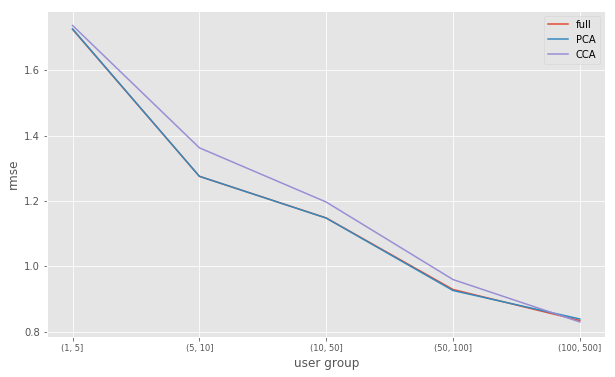

In [46]:
x_labels = ['(1, 5]','(5, 10]','(10, 50]','(50, 100]','(100, 500]']
x = range(len(x_labels))

plt.figure(figsize=(10,6))
plt.plot(x, rmses_full, label='full')
plt.plot(x, rmses_pca, label='PCA')
plt.plot(x, rmses_cca, label='CCA')
plt.xticks(range(len(x_labels)), x_labels, size='small')
plt.xlabel('user group')
plt.ylabel('rmse')
plt.legend()
plt.show()

In [45]:
db.close()